In [1]:
import re
import json
import dateparser
# from pyrallel.parallel_processor import ParallelProcessor, Mapper
import spacy
import pandas as pds
from utils import parse_date, match_dates_based_on_precision

/nas/home/amandeep/miniconda3/envs/python3/lib/python3.9/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
nlp = spacy.load('en_core_web_trf')

In [3]:
wikipedia_url_regex = re.compile(r'http:\/\/(.*)\.wikipedia\.org\/wiki\/(.*)')

In [4]:
dpr_answer_file = '../data/marriages_wikidata.dpr.answers.pyserini.50k.jl'

In [5]:
q_to_p_dict = json.load(open('../data/questions_o_precision_dict.json'))

In [6]:
len(q_to_p_dict)

68158

In [7]:
def filter_dpr_documents(dpr_answer_file):
    dpr_answers = open(dpr_answer_file)
    filtered_dpr_answers = []
    no_matching_title = []
    for dpr_answer in dpr_answers:
        dpr = json.loads(dpr_answer)
        wiki_title_url = ' '.join(re.search(wikipedia_url_regex, dpr['url']).group(2).lower().split('_'))
        answers = dpr['dpr_answers']
        filtered_answers = []
        for i, a in enumerate(answers):
            a['rank'] = i+1
            wiki_title_dpr = a['dpr_answer'].split('\n')[0].lower().replace('"', '')
            if wiki_title_dpr == wiki_title_url:
                filtered_answers.append(a)
        if len(filtered_answers) > 0:
            dpr['filtered_answers'] = filtered_answers
            filtered_dpr_answers.append(dpr)
        else:
            no_matching_title.append(dpr)
    dpr_answers.close()
    print(f'no matching title count: {len(no_matching_title)}')
    return filtered_dpr_answers, no_matching_title

In [8]:
filtered_answers, no_matching_title = filter_dpr_documents(dpr_answer_file)

no matching title count: 29119


In [9]:
len(filtered_answers)

25181

In [ ]:
pretty_print_json(filtered_answers[233]['filtered_answers'])

In [10]:
def pretty_print_json(json_doc):
    print(json.dumps(json_doc, indent=2))

In [11]:
one_para = filtered_answers[0]['filtered_answers'][0]['dpr_answer']
one_para

'"Ranbir Kapoor"\nlife. Rumours of an affair with Katrina Kaif first emerged during the production of ""Ajab Prem Ki Ghazab Kahani"" in 2009. In August 2013, a set of paparazzi photographs of Kapoor and Kaif at a beach in Spain were published by ""Stardust"". Although Kapoor initially declined to speak of the relationship, he admitted to it in 2015: ""Both of us are sure about our relationship and if we don\'t open about it now, it would be showing disrespect to the relationship."" As of February 2016, the media reported that they had broken up. In 2018, he began dating Alia Bhatt,'

In [12]:
parse_date(one_para, nlp)

/nas/home/amandeep/miniconda3/envs/python3/lib/python3.9/site-packages/torch/autocast_mode.py:162: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn('User provided device_type of \'cuda\', but CUDA is not available. Disabling')
/nas/home/amandeep/miniconda3/envs/python3/lib/python3.9/site-packages/dateparser/date_parser.py:35: PytzUsageWarning: The localize method is no longer necessary, as this time zone supports the fold attribute (PEP 495). For more details on migrating to a PEP 495-compliant implementation, see https://pytz-deprecation-shim.readthedocs.io/en/latest/migration.html
  date_obj = stz.localize(date_obj)


[{'date': '2009-07-01', 'year': 2009, 'month': '07', 'day': '01'},
 {'date': '2013-08-01', 'year': 2013, 'month': '08', 'day': '01'},
 {'date': '2015-07-01', 'year': 2015, 'month': '07', 'day': '01'},
 {'date': '2016-02-01', 'year': 2016, 'month': '02', 'day': '01'},
 {'date': '2018-07-01', 'year': 2018, 'month': '07', 'day': '01'}]

In [13]:
def process_dpr(line, answer_field='filtered_answers'):
    dpr_answers = line[answer_field]
    for da in dpr_answers:
        parsed_dates = parse_date(da['dpr_answer'], nlp)
        if parsed_dates:
            da['parsed_dates'] = parsed_dates
    return json.dumps(line)q_to_p_dict

In [14]:
out = open('../data/dpr-post-process-filtered.jl', 'w')
c = 1
for line in filtered_answers:
    if c % 1000 == 0:
        print(c)
    c += 1
    out.write(f'{process_dpr(line)}\n')

1000
2000
3000
4000
5000
6000
7000
8000
9000
10000
11000
12000
13000
14000
15000
16000
17000
18000
19000
20000
21000
22000
23000
24000
25000


In [57]:
def match_dpr_dates(input_file, output_file, dpr_answer_field='filtered_answers'):
    out = open(output_file, 'w')
    f = open(input_file)
    c = 0 
    filtered_not_matched = []
    for line in f:
        any_match = False
        c += 1
        j = json.loads(line.strip())
        j['precision'] = q_to_p_dict[j['q']]
        j.pop('dpr_answers')
        answers = j[dpr_answer_field]
        for ans in answers:
            matched = False
            parsed_dates = ans.get('parsed_dates', None)
            if parsed_dates:
                for pd in parsed_dates:                    
                    matched, prov = match_dates_based_on_precision(j['a'], q_to_p_dict[j['q']], pd)
                    if j['q'] == 'when did Chiara Ferragni marry Fedez?':
                        print(matched, pd, j['a'])

                    if matched:
                        ans['prov'] = prov
                        any_match = True
                        break
            if j['q'] == 'when did Chiara Ferragni marry Fedez?':
                print(matched)
            ans['matched'] = matched
        if not any_match:
            filtered_not_matched.append(j)
        else:
            j['spacy_matched'] = any_match
        out.write(json.dumps(j))
        out.write('\n')
    return filtered_not_matched

In [58]:
filtered_not_matched = match_dpr_dates('../data/dpr-post-process-filtered.jl', 
                                       '../data/dpr-post-process-filtered-matched.jl')

False {'date': '2015-07-01', 'year': 2015, 'month': '07', 'day': '01'} 2018-09-01
False {'date': '2015-07-01', 'year': 2015, 'month': '07', 'day': '01'} 2018-09-01
False {'date': '2017-05-06', 'year': 2017, 'month': '05', 'day': '06'} 2018-09-01
True {'date': '2018-09-01', 'year': 2018, 'month': '09', 'day': '01'} 2018-09-01
True


In [47]:
len(filtered_not_matched)

11826

In [59]:
processed_file = open('../data/dpr-post-process-filtered-matched.jl')
c = 0
for l in processed_file:
    j = json.loads(l.strip())
    fas = j['filtered_answers']
    for fa in fas:
        if j['q'] == 'when did Chiara Ferragni marry Fedez?':
            print(fa['matched'])
        if fa['matched']:
            # print(f"{j['q']}\t{fa['dpr_answer']}\t{j['a']}")
            c += 1
print(c)
processed_file.close()

True
14775


In [60]:
def filter_matched_answers(input_file, output_file, dpr_field='filtered_answers'):
    i_f = open(input_file)
    o = open(output_file, 'w')
    out = []
    for line in i_f:
        j = json.loads(line.strip())
        if j['q'] == 'when did Chiara Ferragni marry Fedez?':
            print(j)
        dpr_answers = j[dpr_field]
        matched_dpr_answers = [x for x in dpr_answers if x['matched']]
        j['matched_dpr_answers'] = matched_dpr_answers
        j.pop(dpr_field)
        if len(matched_dpr_answers) > 0:
            out.append(j)
    o.write(json.dumps(out))

In [61]:
filter_matched_answers('../data/dpr-post-process-filtered-matched.jl', 
                       '../data/dpr-post-process-filtered-matched-gt.json')

{'q': 'when did Chiara Ferragni marry Fedez?', 'a': '2018-09-01', 'n1': 'Q8933801', 'n2': 'Q3741984', 'n1_label': 'Chiara Ferragni', 'n2_label': 'Fedez', 'url': 'http://en.wikipedia.org/wiki/Chiara_Ferragni', 'filtered_answers': [{'dpr_answer': '"Chiara Ferragni"\nin Business of Fashion 500 most influential fashion people. In 2015, Ferragni won the ""Bloglovin\' Award"" ""Blogger of the Year"". In 2015 Ferragni was listed in the ""Forbes 30 Under 30. Chiara and Italian rapper and producer Federico Lucia, known as Fedez started dating in late 2016. They got engaged on May 6, 2017, during his concert in Verona; the concert and proposal were broadcast live on the Italian radio and TV channel RTL 102.5. The wedding took place in Noto, Sicily on September 1, 2018. She and Fedez have one son together, Leone (born March 19, 2018). They live', 'dpr_score': 75.49678802490234, 'dpr_docid': '17730028', 'rank': 3, 'parsed_dates': [{'date': '2015-07-01', 'year': 2015, 'month': '07', 'day': '01'}, {

wikidata precision meaning

 - 14 second
 - 13 minute
 - 12 hour
 - 11 day
 - 10 month
 - 9 year
 - 8 decade
 - 7 century
 - 6 millenium
 - 4 hundred thousand years
 - 3 million years
 - 0 billion years


distribution of precision in wikidata marriage time qualifier dates:
{'11': 35604, '10': 2222, '9': 30256, '8': 76, '5': 2, '7': 4}

In [62]:
gt_questions = json.load(open('../data/dpr-post-process-filtered-matched-gt.json'))

In [52]:
len_distribution = {}
rank_distribution = {}
prov_distribution = {}
for gq in gt_questions:
    answers = gq['matched_dpr_answers']
    la = len(answers)
    # if rank == 100:
    #     pretty_print_json(gq)
    if la not in len_distribution:
        len_distribution[la] = 0
    len_distribution[la] += 1
    for a in answers:
        # if a['rank'] == 100:
            # pretty_print_json(gq)
        rank = a['rank']
        if rank  not in rank_distribution:
            rank_distribution[rank] = 0
        rank_distribution[rank] += 1
        if a['prov']  not in prov_distribution:
            prov_distribution[a['prov']] = 0
        prov_distribution[a['prov']] += 1

In [53]:
print(rank_distribution)

{25: 78, 1: 4184, 4: 760, 17: 120, 8: 316, 2: 1900, 35: 56, 34: 60, 42: 48, 3: 1096, 12: 214, 5: 560, 23: 107, 20: 116, 18: 125, 47: 38, 38: 56, 9: 256, 7: 377, 37: 64, 10: 233, 52: 23, 30: 51, 16: 139, 44: 36, 6: 455, 73: 31, 69: 27, 33: 61, 21: 94, 49: 37, 91: 35, 11: 206, 57: 48, 92: 18, 29: 73, 22: 86, 26: 79, 19: 124, 28: 75, 61: 30, 31: 59, 98: 19, 68: 32, 100: 16, 51: 39, 14: 151, 15: 159, 66: 23, 59: 35, 27: 76, 67: 19, 76: 27, 95: 31, 32: 68, 93: 18, 71: 23, 40: 52, 43: 45, 53: 34, 55: 49, 77: 30, 64: 44, 96: 25, 36: 50, 13: 162, 90: 30, 72: 26, 45: 47, 70: 35, 65: 17, 62: 28, 50: 32, 46: 34, 58: 36, 83: 16, 81: 20, 24: 72, 56: 25, 60: 40, 75: 33, 87: 33, 63: 28, 78: 25, 84: 23, 99: 10, 94: 27, 82: 26, 54: 35, 41: 45, 85: 28, 48: 36, 79: 23, 39: 41, 89: 27, 74: 20, 88: 23, 97: 17, 80: 22, 86: 17}


In [22]:
rank_df = pds.DataFrame([{'rank': x, 'count': rank_distribution[x]} for x in rank_distribution]).sort_values(by='rank')
len_df = pds.DataFrame([{'length': x, 'count': len_distribution[x]} for x in len_distribution]).sort_values(by='length')
prov_df = pds.DataFrame([{'precision': x, 'count': prov_distribution[x]} for x in prov_distribution])

<AxesSubplot:xlabel='rank', ylabel='count'>

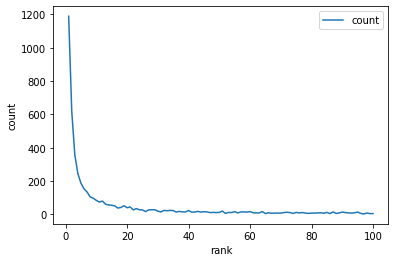

In [23]:
rank_df.plot(kind='line', x='rank', y='count', ylabel='count')

<AxesSubplot:xlabel='length', ylabel='count'>

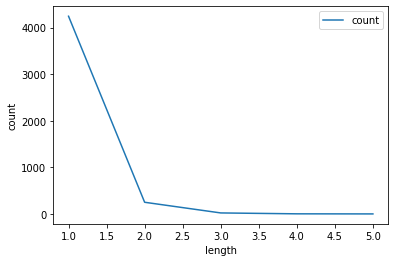

In [24]:
len_df.plot(kind='line', x='length', y='count', ylabel='count')

<AxesSubplot:xlabel='precision', ylabel='count'>

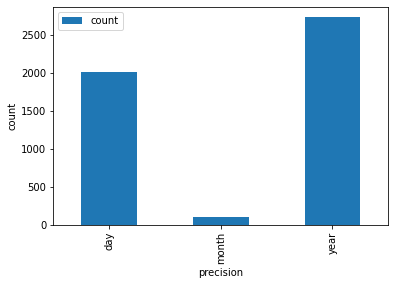

In [25]:
prov_df.plot(kind='bar', x='precision', y='count', ylabel='count')

In [ ]:
len(filtered_not_matched)

In [26]:
len(gt_questions)

4519

In [54]:
annotated_f = open('../data/unified-qa-metrics-annotated.tsv')
annotated = {}
for line in annotated_f:
    vals = line.strip().split('\t')
    answerable = vals[5]
    if answerable == 'yes':
        annotated[vals[0]] = answerable
annotated_f.close()

In [55]:
gt_d = {}
for gt_q in gt_questions:
    gt_d[gt_q['q']] = gt_q

In [56]:
c = 0
for a in annotated:
    if a not in gt_d:
        c+=1
        print(a)
        
c  

0